# Implementation of Reuter 2015 snowpack point instability (modified)

## Notes:
- r_c estimation flat field? / on the slope, r_c varies and depends on up or down cutting.  38° upslope cutting are may even unstable. --> maybe we should switch to vertical beam ends compute r_c on the slope?
    - 38° upslope cutting, makes deeper layers much more unstable.
- S is derived from a 38° slope, either with slab load or without slab load.
- For skier stability index, I did not neglect the slab induced shear stress as this makes shallow layers more unstable. (Reuter neglected)

- incrementel energy release rate could be used as an alternative?
- different mathematical ways are testet to combine the metrics r_c and S
  
- wf is not devided by any area and the 2mm window is arbitrary
- why not taking the compressive stress??
- penetraton depth
- run with 2mm full layering
- 



## point stablity class

In [63]:
import pandas as pd
import numpy as np
import sys
sys.path.append('D:\\SMP_stability\\weac')
import weac as weac
from Emod_parametrizations import e_gerling_2017_AC
import matplotlib.pyplot as plt
import itertools


class R2015_point_instability:
    def __init__(self, file_path,
                 skier_stability_params = {"totallength":4e4, "inclination":-38, "skierweight":80, "slab_load":True},
                 PST_params = {"system":"pst-", "totallength":4e3,"inclination":-38, "max_cracklength":2e3, "num_da": 500},              
                                           ):
        """
        Initializes the class with a layered snow profile.
        
        Parameters:
        - file_path: str, path to the layered snow profile pickle file
        - skier_stability_params: dict, to initialize weac:
            - totallength: float, lateral length of simulated snowpack in mm
            - skierweight: float, skier weight in kg
            - inclination: float, slope angle in degrees, negative clockwise
            - slab_load: bool, True or False matter if the stress, induced by the overlying slab, should be accounted for
        - PST_params: dict, to initialize weac:
            - system: string, slope normal beam ends '-pst', 'pst-' or vertial '-vpst', 'vpst-'; minus is cutting direction
            - totallength: float, lateral length of simulated snowpack in mm
            - inclination: float, slope angle in degrees, negative clockwise
            - max_cracklength: float, maximal crack length for which Energy release is computed in mm
            - num_da: float, number of infeniesimal crack increments within max_cracklength

        """
        self.file_path = file_path
        self.skier_stability_params = skier_stability_params
        self.PST_params = PST_params
        self.df = self._load_profile()

    def _load_profile(self):
        """Loads the snow profile from a pickle file and computes additional parameters."""
        df = pd.read_pickle(self.file_path)

        # Compute additional material properties
        df['G2017_E_AC'] = df['CR2020_density'].apply(e_gerling_2017_AC)

        df["JS1999_sigma_n"] = df.L2012_f0 / (df.L2012_L ** 2)
        df.JS1999_sigma_n.attr = "N/mm^2, MPa- Microstructural element compressive strength"

        df["JS1999_sigma_macro"] = df.JS1999_sigma_n * (df.L2012_delta / df.L2012_L)
        df.JS1999_sigma_macro.attr = "N/mm^2, MPa - macroscale compressive strength"

        # Compute layer weight (load above weak layer)
        layer_weight = df.CR2020_density * df.thickness/1000  # kg/m^2
        layer_weight = layer_weight.cumsum().shift(1, fill_value=0)  # Accumulate weight of layers above
        layer_weight = layer_weight * -9.81  # Convert to Pa
        df["load_above"] = layer_weight
        df.load_above.attrs['unit'] = "kg/m^2, Pa"

        return df

    def _get_slab_profile_for_weac(self, wl_id):
        """Loads the snow profile from a pickle file and computes additional parameters."""
        density = self.df["CR2020_density"].values
        thickness = self.df["thickness"].values
        slab_profile = np.column_stack((density, thickness))[:wl_id, :].tolist()
        return slab_profile

    

#---------- S computation --------------------------------    
    def _compute_tau(self, weak_layer_id):
        """Computes shear stress along a given weak layer."""
        skier = weac.Layered(system='skier', layers=self._get_slab_profile_for_weac(weak_layer_id))
        seg_skier = skier.calc_segments(L=self.skier_stability_params["totallength"], m=self.skier_stability_params["skierweight"])['nocrack']
        C_skier = skier.assemble_and_solve(phi=self.skier_stability_params["inclination"], **seg_skier)
        xsl_skier, z_skier, xwl_skier = skier.rasterize_solution(C=C_skier, phi=self.skier_stability_params["inclination"], **seg_skier)
        x, tau = skier.get_weaklayer_shearstress(xwl_skier, z_skier, unit="kPa")
        return(x,tau)
        
    def _compute_max_tau(self, weak_layer_id):
        """Computes max shear stress for a given weak layer without the static stress induce by the slab"""
        x, tau = self._compute_tau(weak_layer_id)
        # Compute maximal shear stress in the weak layer max_tau_skier
        if self.skier_stability_params["slab_load"]: # take the full shear stress in the weak layer
            tau_skier = tau
        else: # take just the additional shear stress induced by the skier
            tau_skier = tau - self.df["load_above"].iloc[weak_layer_id] / 1e3 * np.sin(np.deg2rad(self.skier_stability_params["inclination"]))
        return max(abs(tau_skier))

    def compute_skier_stability_S(self):
        """Computes the stability ratio S_Reuter2015 and adds it to the DataFrame."""
        max_tau_skier = self.df.index.to_series().apply(self._compute_max_tau)
        self.df["S_Reuter2015"] = self.df["JS1999_sigma_macro"] * 1e3 / max_tau_skier

#---------- rc computation --------------------------------    
    def _compute_rc_layer(self, weak_layer_id):
        """Computes rc for a given weak layer."""
        pst = weac.Layered(system=self.PST_params["system"], layers=self._get_slab_profile_for_weac(weak_layer_id))
    
        # Initialize outputs and crack lengths
        Gdif = np.zeros([3, self.PST_params["num_da"]])
        da = np.linspace(1e-6, self.PST_params["max_cracklength"], num=self.PST_params["num_da"])
        
        # Loop through crack lengths
        for i, a in enumerate(da):
            # Obtain lists of segment lengths, locations of foundations.
            seg_err = pst.calc_segments(L=self.PST_params["totallength"], a=a)
            # Assemble system and solve for free constants
            C1 = pst.assemble_and_solve(phi=self.PST_params["inclination"], **seg_err['crack']) 
            # Compute differential and incremental energy release rates
            Gdif[:, i] = pst.gdif(C1, self.PST_params["inclination"], **seg_err['crack'])
        
        w_f = self.df["R2015_wf"][weak_layer_id]
        r_c = da[Gdif[0, :]*1000 > w_f].min()/10
        return(r_c)


    def compute_critical_cut_length_rc(self):
        """Computes rc for a given weak layerand adds it to the DataFrame."""
        self.df["rc_Reuter2015"] = self.df.index.to_series().apply(self._compute_rc_layer)


#---------- other methods -------------------------------- 

    def compute_harmonic_mean(self):
        """combines S and rc to a single metric"""
        I1,I2 = self.df.S_Reuter2015, self.df.rc_Reuter2015
        self.df["harmonic_mean"] = (2*I1*I2) / (I1+I2)
    def compute_logarithmic_mean(self):
        """combines S and rc to a single metric"""
        I1,I2 = self.df.S_Reuter2015, self.df.rc_Reuter2015
        self.df["logarithmic_mean"] = (I1-I2) / (np.log(I1)-np.log(I2))
    def compute_geometric_mean(self):
        """combines S and rc to a single metric"""
        I1,I2 = self.df.S_Reuter2015, self.df.rc_Reuter2015
        self.df["geometric_mean"] = np.sqrt(I1*I2)
    def compute_reziprocal_sum(self):
        """combines S and rc to a single metric"""
        I1,I2 = self.df.S_Reuter2015, self.df.rc_Reuter2015
        self.df["reziprocal_sum"] = 1/(1/I1+1/I2)
    def compute_logarithmic_sensitivity(self):
        """combines S and rc to a single metric"""
        I1,I2 = self.df.S_Reuter2015, self.df.rc_Reuter2015
        self.df["logarithmic_sensitivity"] = np.exp(np.log(I1)+np.log(I2))
        
    def get_dataframe(self):
        """Returns the processed DataFrame."""
        return self.df

#---------- Plotting --------------------------------    
    def plot_density_profile(self, ax=None):
        """Plots the density profile as blocks, using thickness for depth scaling."""
        if "CR2020_density" not in self.df or "thickness" not in self.df:
            print("Error: Required columns missing in DataFrame.")
            return None
    
        # Compute depth by cumulative sum of thickness
        self.df["depth_top"] = self.df["thickness"].cumsum().shift(1, fill_value=0)
        self.df["depth_bottom"] = self.df["depth_top"] + self.df["thickness"]
    
        # Set density x-limit slightly beyond the max value
        density_xmax = self.df["CR2020_density"].max() * 1.1  # 10% padding
    
        if ax is None:
            fig, ax = plt.subplots(figsize=(7, 8))
    
        # Plot density as blocks
        for _, row in self.df.iterrows():
            ax.fill_betweenx(
                [row["depth_top"], row["depth_bottom"]],
                0, row["CR2020_density"],
                color='lightblue', edgecolor='black', linewidth=1, alpha=0.6
            )
    
        # Labels & Formatting
        ax.set_xlabel("Density (kg/m³)", color="blue")
        ax.set_ylabel("Depth (mm)")
        ax.invert_yaxis()  # Depth increases downward
        ax.grid(True, linestyle="--", alpha=0.6)
        ax.set_xlim(0, density_xmax)  # Ensure full density range + padding
        ax.tick_params(axis='x', colors='blue')  # Color density axis for clarity
    
        return ax
 
    
    def plot_normalized_metric(self, metric, ax=None):
        """normalizes a stability metric and adds it to existing axis."""
        def _get_next_color(ax):
            """Returns the next color in the Matplotlib color cycle for the given axis."""
            num_lines = len(ax.get_lines())  # Count the existing graphs
            
            # Get the default color cycle
            prop_cycle = plt.rcParams['axes.prop_cycle']
            colors = itertools.cycle(prop_cycle.by_key()['color'])  # Cycle through colors
            
            # Pick the next color based on the number of lines
            for _ in range(num_lines):
                next(colors)  # Skip colors already used
            return next(colors)  # Return the next available color  
        
        if ax is None:
            fig, ax = plt.subplots(figsize=(7, 8))
        depth = self.df["thickness"].cumsum()

        if metric not in self.df: 
            if metric == "S_Reuter2015":  self.compute_skier_stability_S()
            if metric == "rc_Reuter2015":  self.compute_critical_cut_length_rc()
            if metric == "harmonic_mean":  self.compute_harmonic_mean()
            if metric == "geometric_mean":  self.compute_geometric_mean()
            if metric == "logarithmic_mean":  self.compute_logarithmic_mean()
            if metric == "reziprocal_sum":  self.compute_reziprocal_sum()
            if metric == "logarithmic_sensitivity":  self.compute_logarithmic_sensitivity()

        
        # make robust metric visualization by normalizing to the 80 percentile
        norm_factor = np.percentile(stability_model.df[metric].dropna(), 80) * 1.05  # 5% padding
        ax.plot(self.df[metric]/norm_factor, depth, marker='o', linestyle='-', color=_get_next_color(ax), label=metric)
                
        # Labels & Formatting
        ax.set_xlim(0, 1.055)  # normalized x-axis limit
        ax.tick_params(axis='x', colors='k')  # Color S axis for clarity    
        return ax
        
    def plot_combined(self,metrics):
        """Plots both stability and density profiles together with dual x-axes."""
        fig, ax1 = plt.subplots(figsize=(7, 8))
    
        ax1 = self.plot_density_profile(ax=ax1)  # Left x-axis for density
        ax2 = ax1.twiny()  # Create second x-axis for stability
        for metric in metrics:
            ax2 = self.plot_normalized_metric(metric, ax=ax2)  # Right x-axis for stability
    
        plt.title("Snowpack Density & Stability Profile")
        plt.legend()
        plt.show()
        return(fig,ax1,ax2)


## Results:

In [64]:
# Example Usage
file_path = '.pnt_data\\190110_BUN\\SMP\\FILE0245_smp_lay.pkl'

skier_stability_params = {"totallength":4e4, "inclination":-38, "skierweight":80,"slab_load":True}
PST_params = {"system":"-vpst", "totallength":4e3,"inclination":0, "max_cracklength":2e3, "num_da": 500}
stability_model = R2015_point_instability(file_path, skier_stability_params = skier_stability_params, PST_params = PST_params)



In [65]:
skier_stability_params

{'totallength': 40000.0,
 'inclination': -38,
 'skierweight': 80,
 'slab_load': True}

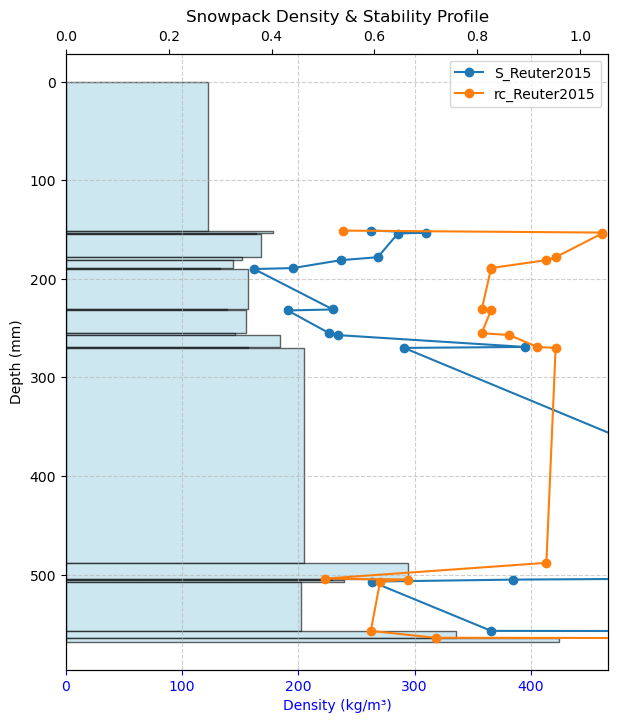

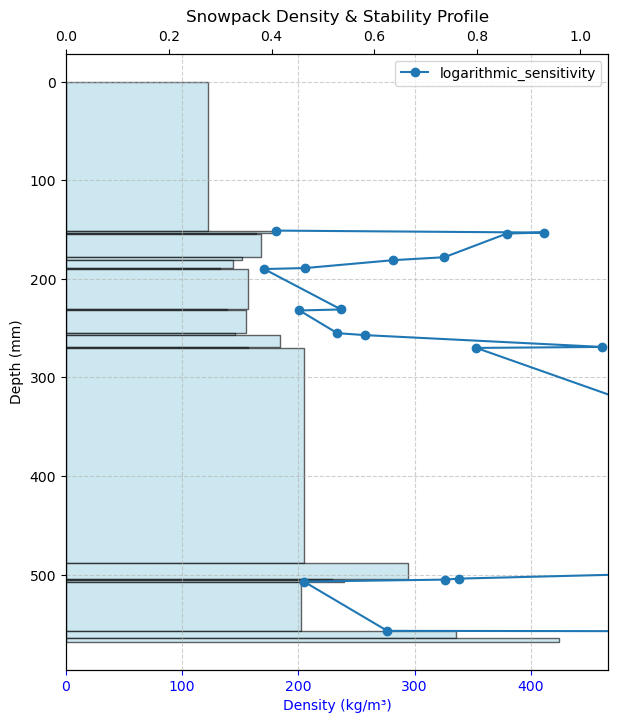

CPU times: total: 656 ms
Wall time: 685 ms


(<Figure size 700x800 with 2 Axes>,
 <Axes: xlabel='Density (kg/m³)', ylabel='Depth (mm)'>,
 <Axes: title={'center': 'Snowpack Density & Stability Profile'}>)

In [72]:
%%time
fig,ax1,ax2 = stability_model.plot_combined(["S_Reuter2015","rc_Reuter2015"])
#stability_model.plot_combined(["geometric_mean","harmonic_mean"])
#stability_model.plot_combined(["logarithmic_mean","reziprocal_sum","logarithmic_sensitivity"])
stability_model.plot_combined(["logarithmic_sensitivity"])
